# Preprocess recorded audio files of connector mating processes of the HVA 280 connector (having two click events during its insertion process) and create labeled dataset with an automated labeling algorithm

This notebook is the implementation of the corresponding part in section ***5.4.1 Dataset*** of the chapter ***5 Experiments*** for creating the connector dataset (referred to as **Dataset 1** in the documentation) for the **HVA 280** connector with chunk sizes 64 × 128. More details on the implementation steps can be found in the thesis.

### 1. Import libraries and moduls

In [1]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

In [12]:
# import necessary functions from the folder "06_Utilities" for audio file processing and mel-spectrogram plotting

cwd = str(Path.cwd())                                               ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent)                                  ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities")  ## full path to the "05_Utilities" folder

sys.path.append(utilities_dir_full_path)                            ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing                                              ## import the modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting                                          ## import the modul for mel-spectrogram visualization
import sharedValues                                                 ## import the modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

### 2. Load recorded audio files

In [3]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) ## sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [4]:
# select dataset (from the datasets recorded without additional noise)
## in case of the connectors used in this work: dataset_num = 2 (HVA 280 connector)

dataset_num = 2
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  03_HVA280


In [6]:
# add audio files from selected dataset to a list

## sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
#audio_files_sorted = sorted(audio_files)

print(f"Dataset length: {len(audio_files_sorted)}")

print("First 5 files in the selected dataset:")
for i in range(5): print(f" - {audio_files_sorted[i]}")                                                     ## print the first 5 audio files in the noise dataset

Dataset length: 60
First 5 files in the selected dataset:
 - HVA280_1.m4a
 - HVA280_2.m4a
 - HVA280_3.m4a
 - HVA280_4.m4a
 - HVA280_5.m4a


### 3. Preprocess noise audio files

In [13]:
# shared parameters used in the project (each value is set according to the documentation)

sampling_rate = sharedValuesConfig.SAMPLING_RATE                                    ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE                                          ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION                                          ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK    ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH                                          ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS                                                  ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN                                                    ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX                                                    ## maximum frequency in Hz
top_dB_abs = sharedValuesConfig.TOP_DB_ABS                                          ## maximum dB value
d_ref = sharedValuesConfig.D_REF                                                    ## reference value for dB conversion
d_min = sharedValuesConfig.D_MIN                                                    ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS                                          ## maximum dB value

In [14]:
# get information about the range of values in the mel-spectrogram
# these infromation is used for the dB conversion

max_amplitude_squere_mel = None
min_amplitude_squere_mel = None

## iterate through all audio files in the dataset
for i in range(len(audio_files_sorted)):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, d_min = None, d_ref = None)
    if i == 0:
        max_amplitude_squere_mel = D_mel.max()
        min_amplitude_squere_mel = D_mel.min()
    else:
        max_amplitude_squere_mel = D_mel.max() if D_mel.max() > max_amplitude_squere_mel else max_amplitude_squere_mel  ## update the max value if the current value is greater
        min_amplitude_squere_mel = D_mel.min() if D_mel.min() < min_amplitude_squere_mel else min_amplitude_squere_mel  ## update the min value if the current value is smaller

print(f"Min amplitude squere in the mel-spectrograms: {min_amplitude_squere_mel}, Max amplitude squere in the mel-spectrograms: {max_amplitude_squere_mel}")

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_fil

Min amplitude squere in the mel-spectrograms: 4.95717670471324e-13, Max amplitude squere in the mel-spectrograms: 219.12644958496094


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


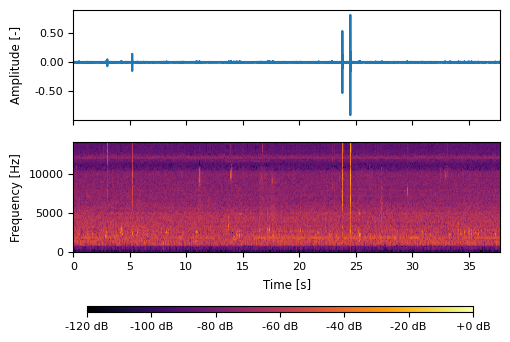

In [16]:
# plot the wave and mel-spectrogram of an audio file from the selected dataset

file_id_num = 0 ## selected file ID number

## in case the file_id_num is in the dataset, plot the wave and mel-spectrogram
if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num]) ## full path to the selected audio file
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, d_min, d_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

### 4. Automated labeling - finding click-events in the wavefrom of the audio files
Note: This works only for files where the amplitude peak can be easily detected, i.e. no other sound with higher amplitude is present in the wavefrom

In [18]:
# calculating peak times for each audio file in the selected dataset based on the maximum absolute value of the signal amplitude

## calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, d_ref):
    signals = []        ## audio wave forms
    signal_times = []   ## time stamps in seconds for all samples in an audio file 
    peak_times_1 = []   ## time of largerst amplitude peak in each signal
    peak_times_2 = []   ## time of 2nd largest amplitude peak in each signal
    spectrograms = []

    ## iterate through all audio files in the folder
    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, d_min, d_ref)
        signals.append(signal)          ## append the signal to the list
        signal_times.append(time)       ## append the time to the list
        spectrograms.append(D_mel_dB)   ## append the mel-spectrogram to the list

        ## search absolute maximal value in the waveform within a search interval
        search_interval_min = 0                                             ## search from the start of the audio signals
        search_interval_min_index = search_interval_min * sampling_rate     ## convert the search interval start time to the index
        search_interval_max_index = len(signal)                             ## search up to the end of the audio

        ## search for the peak in the signal
        j = search_interval_min_index
        peak_index_1 = j
        while j < search_interval_max_index-1:      ## iterate through the search interval
            if signal[j+1] > signal[peak_index_1]:
                peak_index_1 = j+1                  ## update the peak index if the current value is greater
            j = j + 1
        
        peak_time_1 = peak_index_1 / sampling_rate  ## convert the peak index to the time in seconds
        peak_times_1.append(peak_time_1)            ## append the peak time to the list

        # search absolute maximal value in the waveform within a search interval outside the epsilon environment of first peak --> second peak

        eps_interval = 0.1                                              ## selected intuitevely, based on plots of the waveforms (epsilon in seconds)
        eps_interval_index_values = int(eps_interval * sampling_rate)   ## number of samples excluded from search in + and - direction
        z = search_interval_min_index                                   ## start of the search interval     
        peak_index_2 = z
        while z < search_interval_max_index-1:
            if (z < peak_index_1 - eps_interval_index_values) or (z > peak_index_1 + eps_interval_index_values):
                if signal[z+1] > signal[peak_index_2]:                  
                    peak_index_2 = z+1                                  ## update the peak index if the current value is greater
            z = z + 1

        peak_time_2 = peak_index_2 / sampling_rate                      ## convert the peak index to the time in seconds
        peak_times_2.append(peak_time_2)                                ## append the peak time to the list


    return signals, signal_times, peak_times_1, peak_times_2, spectrograms 

## get the waveform, signal times and peak times for the selected dataset
signals, signal_times, peak_times_1, peak_times_2, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, d_ref)

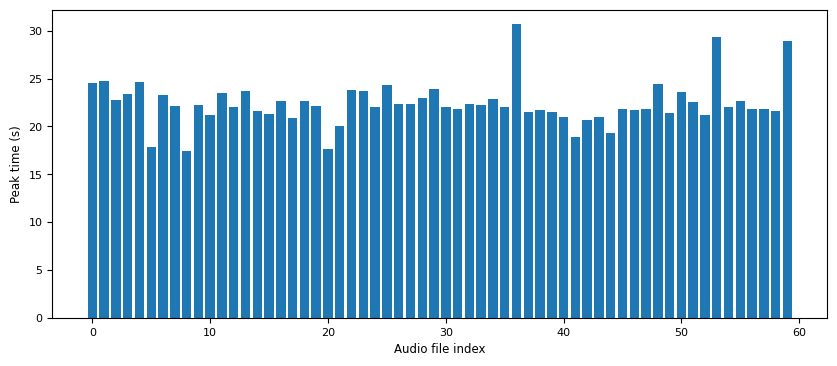

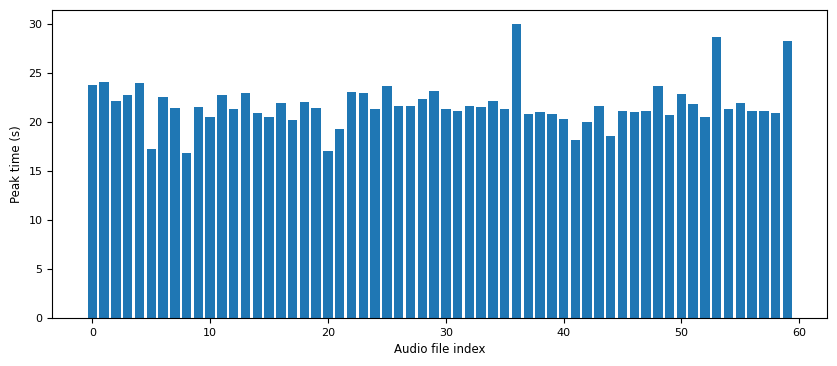

Mean of the peak times in the peg-in-hole process: 22.403921354166666


In [19]:
# check if the identified peak times are around the same time for all audio files -> same robotic peg-in-hole event was recorded with nearly the same start and stop times
## --> outliers should be checked individually

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_1)), peak_times_1)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

# plot for second peak times

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_2)), peak_times_2)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')
plt.show()


print(f"Mean of the peak times in the peg-in-hole process: {np.mean(peak_times_1)}")

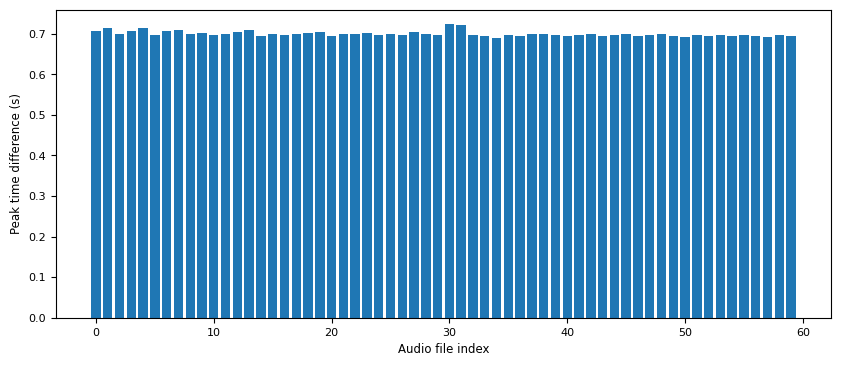

In [20]:
# for more insights, plot time absolut differences between the time of the first and second peaks

## changing peak_time_1 and the corresponding peak_time_2 values based on which one occures first
for i in range(len(peak_times_1)):
    if peak_times_1[i] > peak_times_2[i]:
        temp = peak_times_1[i]
        peak_times_1[i] = peak_times_2[i]
        peak_times_2[i] = temp

peak_times_1_arr = np.array(peak_times_1)               ## convert the list to numpy array
peak_times_2_arr = np.array(peak_times_2)               ## convert the list to numpy array

peak_time_diff = peak_times_2_arr - peak_times_1_arr    ## calculate the time difference between the first and second peak

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_time_diff)), peak_time_diff)
plt.xlabel('Audio file index')
plt.ylabel('Peak time difference (s)')
plt.show()

1.024
23.8093125 24.5156875
0.512


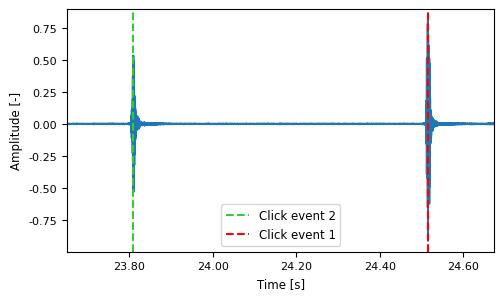

In [21]:
# plot the signal interval around the amplitude peaks for the same audio file in the selected dataset as the first spectrogram plot above

time_interval = (chunk_size/sampling_rate) * 8 
## this will be the investigated interval in real time detection--> 8 spectrogram inputs with 4096 samples each --> with the 32 kHz sampling rate corresponds to an 1.024-second interval
print(time_interval)

signal = signals[file_id_num]               ## get the wavefrom of the selected audio file
time = signal_times[file_id_num]            ## get the time stamps of the selected audio file
peak_time_1 = peak_times_1[file_id_num]     ## get the time of the first peak of the selected audio file
peak_time_2 = peak_times_2[file_id_num]     ## get the time of the second peak of the selected audio file
print(peak_time_1, peak_time_2)

interval = time_interval/2                  ## for setting the x mina and max limits of the plot --> peak time +/- interval
print(interval)

spectrogramPlotter.plot_signal_interval_with_2_peaks(signal, time, peak_time_1, peak_time_2, interval)

### 5. Go through the spectrogram of each audio recording with a sliding window and create a labeled dataset
In the real-time detection, a time frame of 1.024 seconds will be investigated for the **HVA 280** connector. This covers 64 spectrogram columns. In real time detection, there is a new spectrogram input at every 0.128 seconds with a size of 8 × 128. These inputs are stakced together to from a 64 × 128 spectrogram. Therfore, every time when there is a new input, the oldest data rolls out from the investigated 64 × 128 spectrogram intervall, all other chunks sift, and the new input spectrogram comes into the investigated interval. For model training, the size of the investigated intervall must be used. Therfore, spectrogram chunks with size of 64 × 128 are created from the spectrograms of the audio recordings and saved to a labeled dataset.

In [22]:
# duration is set to be large enough to cover both click events (occuring with around 0.7 second time difference with the insertion speed set)

window_size = sharedValuesConfig.WINDOW_SIZE_LONG   ## in this case 64, number of spectrogram columns in the window
## -> corresponds to 1.024 seconds, 8 chunks with 4096 samples each, covers both click events for cerain windows

step_size = sharedValuesConfig.STEP_SIZE            ## in this case 8, number of spectrogram columns in the step size
## corresponds 0.128 seconds --> 0.875 overlap

print(window_size, step_size)

64 8


In [23]:
# create spectrogram chunks and corresponding labels, and store them in lists

spec_chunk_dataset = []     ## list of spectrogram chunks
spec_chunk_labels = []      ## list of labels
signal_chunks = []          ## list of signal waveform chunks
time_chunks = []            ## list of time stamps for the signal chunks

def createSpectrogramDataset(spectrograms, signals, signal_times, peak_times_1, peak_times_2):
    for i in range(len(spectrograms)):                      ## iterate through all audio files
        spectrogram = spectrograms[i]                       ## get the mel-spectrogram of the audio file
        signal = signals[i]                                 ## get the waveform of the audio file
        time = signal_times[i]                              ## get the time stamps of the audio file
        peak_time_1 = peak_times_1[i]                       ## get the time of the first peak of the audio file
        peak_time_1_index = int(peak_time_1 / resolution)   ## convert the peak time to the index of the spectrogram
        peak_time_2 = peak_times_2[i]                       ## get the time of the second peak of the audio file
        peak_time_2_index = int(peak_time_2 / resolution)   ## convert the peak time to the index of the spectrogram

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size                               ## calculate the end index of chunk
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]            ## get the spectrogram chunk
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]  ## get the signal chunk
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]    ## get the time chunk
            
            ## check if the peak time is in the chunk, if yes set the label to 1, otherwise to 0
            if start_idx <= peak_time_1_index < end_idx and start_idx < peak_time_2_index <= end_idx:
                label = 1
            else:
                label = 0

            spec_chunk_dataset.append(spectrogram_chunk)        ## append the spectrogram chunk to the list
            spec_chunk_labels.append(label)                     ## append the label to the list
            signal_chunks.append(signal_chunk)                  ## append the signal chunk to the list
            time_chunks.append(time_chunk)                      ## append the time chunk to the list

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times, peak_times_1, peak_times_2)

## get information about the created lists

print(f"chunk dataset length: {len(spec_chunk_dataset)}")           ## number of spectrogram chunks
print(len(spec_chunk_labels))                                       ## number of labels
print(f"positive samples: {spec_chunk_labels.count(1)}")            ## number of chucnks containing click events 
                                                                    ## --> because of the window overlap it is larger than the number of files
                                                                    ## --> multiple consecutive chunks can contain the click event
print([i for i, x in enumerate(spec_chunk_labels) if x == 1][:10])  ## indices of the chunks containing click events, first 10


chunk dataset length: 16045
16045
positive samples: 161
[184, 185, 186, 474, 475, 476, 746, 747, 1031, 1032]


### 6. Balance the dataset
The number of chunks labeled as not clicks is several times higher than the number of chunks labeled as clicks.

In [25]:
# Reduce the number of negative samples (labeled as 0) to be 10 times the number of positive samples (labeled as 1)

np.random.seed(42)

def balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks):
    positive_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 1]                               ## get the indices of the chunks containing click events
    negative_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 0]                               ## get the indices of the chunks not containing click events
    negative_indices_to_keep = np.random.choice(negative_indices, len(positive_indices)*10, replace=False)  ## randomly select 10 times the number of positive samples from the negative samples
    indices_to_keep = np.concatenate((positive_indices, negative_indices_to_keep))                          ## concatenate the indices of the positive and selected negative samples
    balanced_spec_chunk_dataset = [spec_chunk_dataset[i] for i in indices_to_keep]                          ## get the spectrogram chunks of the selected indices
    balanced_spec_chunk_labels = [spec_chunk_labels[i] for i in indices_to_keep]                            ## get the labels of the selected indices
    balanced_signal_chunks = [signal_chunks[i] for i in indices_to_keep]                                    ## get the signal chunks of the selected indices
    balanced_time_chunks = [time_chunks[i] for i in indices_to_keep]                                        ## get the time chunks of the selected indices

    return balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks

balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks = balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks)

## get information about the balanced dataset

print(f"balanced chunk dataset length: {len(balanced_spec_chunk_dataset)}")     ## number of spectrogram chunks
print(len(balanced_spec_chunk_labels))                                          ## number of labels
print(f"positive samples: {balanced_spec_chunk_labels.count(1)}")               ## number of chucnks containing click events

print(np.min(balanced_spec_chunk_dataset))
print(np.max(balanced_spec_chunk_dataset))

balanced chunk dataset length: 1771
1771
positive samples: 161
-120.0
-6.593052


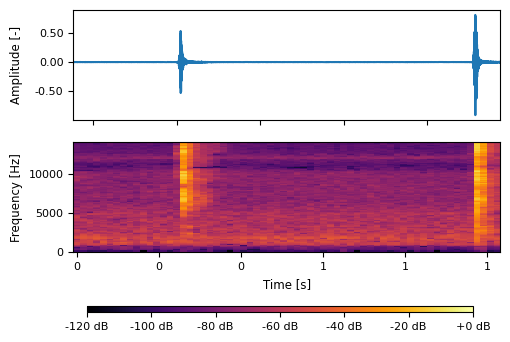

In [26]:
# plot one positive sample from the dataset

chunk_id_to_plot = 0

spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], balanced_spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)

### 7. Save the labeled dataset to the same folder as the processed audio files, in .npz format

In [27]:
# save the spectrogram dataset and labels in .npz format into the same directory as the audio files

save_directory = audio_dataset_dir
filename = "hva280_dataset.npz"
file_fullpath = os.path.join(save_directory, filename)

balanced_spec_chunk_dataset_arr = np.array(balanced_spec_chunk_dataset)     ## convert the list to numpy array
balanced_spec_chunk_labels_arr = np.array(balanced_spec_chunk_labels)       ## convert the list to numpy array

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=balanced_spec_chunk_dataset_arr, labels=balanced_spec_chunk_labels_arr)

(128, 64)
1771
1771
161


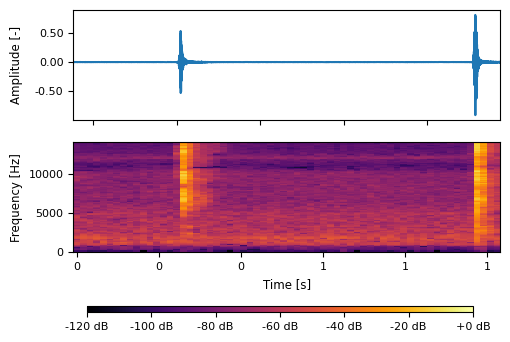

In [28]:
# check if saving was successful by loading the saved dataset and plotting one chunk from the dataset with the same ID as above

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))
# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# plot out one spectrogram chunk
spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)